# Food Supply Chain Security Using Homomorphic MAC and Merkle Tree

### Install required packages

In [1]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import necessary packages

In [2]:
import hashlib
import json
import random
import time
import json
import sys
import os

### Merkle tree predefined functions

In [3]:
import hashlib
import json

# Hash a single sensor entry into a leaf
def hash_sensor_entry(entry):
    sensor_str = f"{entry['timestamp']}|{entry['temperature']}|{entry['humidity']}|{entry['location']}"
    return hashlib.sha256(sensor_str.encode()).hexdigest()

# Build the full Merkle Tree
def build_merkle_tree(leaves):
    if not leaves:
        return []
    tree = [leaves[:]]  # Copy initial leaves
    while len(tree[-1]) > 1:
        current_level = tree[-1]
        next_level = []
        for i in range(0, len(current_level), 2):
            left = current_level[i]
            right = current_level[i + 1] if i + 1 < len(current_level) else left
            combined = left + right
            parent = hashlib.sha256(combined.encode()).hexdigest()
            next_level.append(parent)
        tree.append(next_level)
    return tree

# Extract Merkle root
def get_merkle_root(tree):
    return tree[-1][0] if tree else None

# Load sensor data and compute leaves
def load_sensor_data(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    sensor_data = data["sensor_data"]
    leaves = [hash_sensor_entry(entry) for entry in sensor_data]
    return sensor_data, leaves

# Merkle proof
def get_merkle_proof(tree, index):
    proof = []
    for level in tree[:-1]:
        sibling_index = index ^ 1
        proof.append(level[sibling_index] if sibling_index < len(level) else level[index])
        index //= 2
    return proof

# Verify proof
def verify_merkle_proof(leaf_hash, proof, root, index):
    computed_hash = leaf_hash
    for sibling_hash in proof:
        if index % 2 == 0:
            combined = computed_hash + sibling_hash  # Left + Right
        else:
            combined = sibling_hash + computed_hash  # Left + Right
        computed_hash = hashlib.sha256(combined.encode()).hexdigest()
        index //= 2
    return computed_hash == root




### Homomorphic Mac predefined functions

In [4]:
import hashlib
from decimal import Decimal, getcontext

# Set decimal precision
getcontext().prec = 12

# Hash input to decimal value
def hash_input(input_str):
    digest = hashlib.sha256(input_str.encode()).hexdigest()
    return Decimal(int(digest, 16) % 10**5)

# Generate homomorphic MAC
def generate_mac_for_value(label: str, value: float, key: Decimal) -> Decimal:
    composite = f"{label}-{value}"
    return hash_input(composite) * key

# Verify aggregate MAC
def verify_mac_for_value(label: str, value: float, provided_mac: Decimal, key: Decimal) -> bool:
    expected_mac = generate_mac_for_value(label, value, key)
    print(f"[DEBUG] Expected MAC for {label}: {expected_mac}")
    print(f"[DEBUG] Provided MAC: {provided_mac}")
    return abs(expected_mac - provided_mac) < Decimal("0.000001")

# Node used only for structure (no rebuild needed now)
class HMACTreeNode:
    def __init__(self, timestamp, temperature, key):
        self.timestamp = timestamp
        self.temperature = Decimal(str(temperature))
        self.key = Decimal(str(key))
        self.tag = self.compute_tag()

    def compute_tag(self):
        composite = f"{self.timestamp}-{self.temperature}"
        hashed = hash_input(composite)
        return hashed * self.key

class HMACTree:
    def __init__(self, key):
        self.key = Decimal(str(key))
        self.aggregate_tag = Decimal(0)
        self.nodes = []

    def insert(self, timestamp, temperature):
        temperature_decimal = Decimal(str(temperature))
        node = HMACTreeNode(timestamp, temperature_decimal, self.key)
        self.nodes.append(node)
        self.aggregate_tag += node.tag  # Algebraic update of the tag

    def compute_aggregates_and_macs(self):
        if not self.nodes:
            return None, None, None, None, None, None

        temperatures = [node.temperature for node in self.nodes]

        avg = sum(temperatures) / len(temperatures)
        min_val = min(temperatures)
        max_val = max(temperatures)

        avg_mac = generate_mac_for_value("AVG", avg, self.key)
        min_mac = generate_mac_for_value("MIN", min_val, self.key)
        max_mac = generate_mac_for_value("MAX", max_val, self.key)

        return avg, min_val, max_val, avg_mac, min_mac, max_mac

    def verify_aggregate_mac(self, label, value, provided_mac):
        return verify_mac_for_value(label, value, provided_mac, self.key)


### Main code

#### Imports

In [9]:
from merkle_tool.merkle import (
    load_sensor_data,
    build_merkle_tree,
    get_merkle_root,
    get_merkle_proof,
    verify_merkle_proof,
    hash_sensor_entry
)

from hmac_tool.hmac import HMACTree  # Updated HMAC Tree
from decimal import Decimal
import json

#### Load Sensor Data and Build Merkle Tree

In [10]:
print("\n--- Loading Initial Sensor Data ---")
raw_data, leaves = load_sensor_data('data/sensor_values.json')
tree = build_merkle_tree(leaves)
root = get_merkle_root(tree)
print(f"Merkle Root: {root}")



--- Loading Initial Sensor Data ---
Merkle Root: fa777d390df381412abdc09bde769a77aa4c6a44a67a90fac57594256984d352


#### Generate Merkle Proof and Verify It

In [11]:

# Choose a leaf to verify
test_index = 2
proof = get_merkle_proof(tree, test_index)
print(f"Proof for leaf index {test_index}: {proof}")
valid = verify_merkle_proof(leaves[test_index], proof, root, test_index)  # PASS index here
print(f"Merkle Proof Verification: {valid}")


Proof for leaf index 2: ['5d2c5671a1c6ea0a41e2eed3d2a08e1c786829bfa3ac2c659eef1a5f927854e0', 'd253b89cf02e59abbeb98eb24e5f68b554ae864735ae66d881de17ef56676e52', 'ea14314e7a2fdd4ce8842910b37621a9154048f496f1fdb71ff2ebbf536e33e0', '8b599542822c73218f8cc9ec6a8e91a42038ab8f43e7c4af5e8e7643056840d7', '3322a7a8636aeb42192f3fdc6ce2365e808bd22df9db5c39d4a9fd224c1e59bb', 'cd7943b6c38be5b6d2819327c039a07e7d71223fdd907c253ded349c48d2256f', '50893605747a92c9b78c609f4275ddc5e78b1a3421d0635577685f5e89cb3915', '32a4792a3128ddbfdd1b2314cdb7f9de52b75f427aea5e8bea0f68c9b93f969d', 'e9bdd800b322569f119d6eb7ea9f10bc6c1c0bb9a84fed80b5caef5015acfdab', 'f1ff2f20ad016a7000c5eb14a746075103e8dcf41b1079953299ce35b1dbe0e8']
Merkle Proof Verification: True


#### HMAC Tree Initialization and Aggregation

In [12]:

# --- HMAC Tree Section ---
print("\n--- HMAC Tree Section ---")

# Step 1: Initialize HMAC Tree
key = Decimal('7.25')  # Shared secret key
hmac_tree = HMACTree(key)

# Step 2: Insert data into HMAC Tree
for entry in raw_data:
    hmac_tree.insert(entry['timestamp'], entry['temperature'])

# Step 3: Compute and verify aggregates with MACs
average, min_temp, max_temp, avg_mac, min_mac, max_mac = hmac_tree.compute_aggregates_and_macs()
print(f"Average Temp: {average}")
print(f"Min Temp: {min_temp}")
print(f"Max Temp: {max_temp}")
print(f"MAC for AVG: {avg_mac}")
print(f"MAC for MIN: {min_mac}")
print(f"MAC for MAX: {max_mac}")

# Step 4: Verification
print(f"Verify AVG MAC: {hmac_tree.verify_aggregate_mac('AVG', average, avg_mac)}")
print(f"Verify MIN MAC: {hmac_tree.verify_aggregate_mac('MIN', min_temp, min_mac)}")
print(f"Verify MAX MAC: {hmac_tree.verify_aggregate_mac('MAX', max_temp, max_mac)}")



--- HMAC Tree Section ---
Average Temp: 24.95965
Min Temp: 20.0
Max Temp: 30.0
MAC for AVG: 579470.75
MAC for MIN: 188275.25
MAC for MAX: 591933.50
[DEBUG] Expected MAC for AVG: 579470.75
[DEBUG] Provided MAC: 579470.75
Verify AVG MAC: True
[DEBUG] Expected MAC for MIN: 188275.25
[DEBUG] Provided MAC: 188275.25
Verify MIN MAC: True
[DEBUG] Expected MAC for MAX: 591933.50
[DEBUG] Provided MAC: 591933.50
Verify MAX MAC: True


#### Simulate Insertion of New Sensor Data

In [13]:

# --- Simulate New Sensor Data Insertion ---
print("\n--- Simulate New Sensor Data Insertion ---")
new_entry = {
    "timestamp": "2025-06-15T18:00:00Z",
    "temperature": 29.3,
    "humidity": 65,
    "location": "Zone-C"
}

# Insert into Merkle Tree
raw_data.append(new_entry)
leaves.append(hash_sensor_entry(new_entry))
updated_tree = build_merkle_tree(leaves)
updated_root = get_merkle_root(updated_tree)

# Insert into HMAC Tree
hmac_tree.insert(new_entry["timestamp"], new_entry["temperature"])

# Recompute and verify updated aggregates
updated_avg, updated_min, updated_max, updated_avg_mac, updated_min_mac, updated_max_mac = hmac_tree.compute_aggregates_and_macs()
print(f"Updated Merkle Root: {updated_root}")
print(f"Updated Average Temp: {updated_avg}")
print(f"Updated Min Temp: {updated_min}")
print(f"Updated Max Temp: {updated_max}")
print(f"Updated MAC for AVG: {updated_avg_mac}")
print(f"Updated MAC for MIN: {updated_min_mac}")
print(f"Updated MAC for MAX: {updated_max_mac}")
print(f"Updated Verify AVG MAC: {hmac_tree.verify_aggregate_mac('AVG', updated_avg, updated_avg_mac)}")



--- Simulate New Sensor Data Insertion ---
Updated Merkle Root: aaf6a5036482e368dd12c8babc113104c90a3629ad5e5b08a16181d798cb5891
Updated Average Temp: 24.9639860140
Updated Min Temp: 20.0
Updated Max Temp: 30.0
Updated MAC for AVG: 660598.25
Updated MAC for MIN: 188275.25
Updated MAC for MAX: 591933.50
[DEBUG] Expected MAC for AVG: 660598.25
[DEBUG] Provided MAC: 660598.25
Updated Verify AVG MAC: True


#### Tampering Simulation

In [14]:

# --- Tampering Simulation ---
print("\n--- Tampering Simulation ---")

# Tamper with last entry's temperature
tampered_entry = raw_data[-1].copy()
tampered_entry["temperature"] = 100.0  # Simulate unrealistic tamper

# Verify Merkle proof with tampered data
tampered_hash = hash_sensor_entry(tampered_entry)
tampered_index = len(leaves) - 1
proof = get_merkle_proof(updated_tree, tampered_index)
valid_merkle = verify_merkle_proof(tampered_hash, proof, updated_root, tampered_index)  # Pass index
print(f"Merkle Verification After Tampering: {valid_merkle}")

# Tampered temperature values
tampered_temps = [Decimal(str(e["temperature"])) for e in raw_data[:-1]] + [Decimal('100.0')]
tampered_avg = round(sum(tampered_temps) / len(tampered_temps), 2)
print(f"Tampered Average: {tampered_avg}")
print(f"Verify AVG MAC After Tampering: {hmac_tree.verify_aggregate_mac('AVG', tampered_avg, updated_avg_mac)}")



--- Tampering Simulation ---
Merkle Verification After Tampering: False
Tampered Average: 25.03
[DEBUG] Expected MAC for AVG: 375412.25
[DEBUG] Provided MAC: 660598.25
Verify AVG MAC After Tampering: False


### Benchmarking Code

#### Imports and Setup

In [16]:
import time
import json
import os
import matplotlib.pyplot as plt
from decimal import Decimal

# Import custom modules (adjust if needed)
from merkle_tool.merkle import build_merkle_tree, get_merkle_root, hash_sensor_entry
from hmac_tool.hmac import HMACTree


####  Load Sensor Data

In [17]:
# Load JSON sensor data (assumes this notebook is in the same folder as 'data/')
data_path = os.path.join('data', 'sensor_values.json')

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Sensor data file not found at: {data_path}")

with open(data_path, 'r') as f:
    sensor_data = json.load(f)["sensor_data"]

print(f"✅ Total Data Points Loaded: {len(sensor_data)}")


✅ Total Data Points Loaded: 1000


#### Split the Dataset

In [18]:
# Use first 10 entries for initial build and rest for insertion
initial_entries = sensor_data[:10]
insertion_entries = sensor_data[10:]


#### Merkle Tree Benchmark

In [19]:
print("🔍 Benchmarking Merkle Tree...")

# Initial Build
initial_leaves = [hash_sensor_entry(entry) for entry in initial_entries]
start_build = time.perf_counter()
merkle_tree = build_merkle_tree(initial_leaves)
merkle_root = get_merkle_root(merkle_tree)
end_build = time.perf_counter()

# Simulated Insertions (rebuilding after each insert)
insert_start = time.perf_counter()
for entry in insertion_entries:
    initial_leaves.append(hash_sensor_entry(entry))
    merkle_tree = build_merkle_tree(initial_leaves)
insert_end = time.perf_counter()

# Timing results
merkle_build_time = round(end_build - start_build, 6)
merkle_insert_time = round(insert_end - insert_start, 6)

print(f"Merkle Root: {merkle_root}")
print(f"Initial Build Time: {merkle_build_time} sec")
print(f"Rebuild Time During Insertions: {merkle_insert_time} sec")


🔍 Benchmarking Merkle Tree...
Merkle Root: 8d2036bfbb5873a6f4ef24993a467ec9fd870fd15d653a85abcd2f90343180ab
Initial Build Time: 0.000215 sec
Rebuild Time During Insertions: 0.744093 sec


#### HMAC Tree Benchmark

In [20]:
print("\n🔍 Benchmarking HMAC Tree...")

key = Decimal('7.25')
hmac_tree = HMACTree(key)

# Initial Build
start_build = time.perf_counter()
for entry in initial_entries:
    hmac_tree.insert(entry["timestamp"], entry["temperature"])
end_build = time.perf_counter()

# Insertions
insert_start = time.perf_counter()
for entry in insertion_entries:
    hmac_tree.insert(entry["timestamp"], entry["temperature"])
insert_end = time.perf_counter()

# Timing results
hmac_build_time = round(end_build - start_build, 6)
hmac_insert_time = round(insert_end - insert_start, 6)

print(f"Initial Build Time: {hmac_build_time} sec")
print(f"Insertion Time: {hmac_insert_time} sec")



🔍 Benchmarking HMAC Tree...
Initial Build Time: 0.000168 sec
Insertion Time: 0.00635 sec


#### Plot Performance Comparison

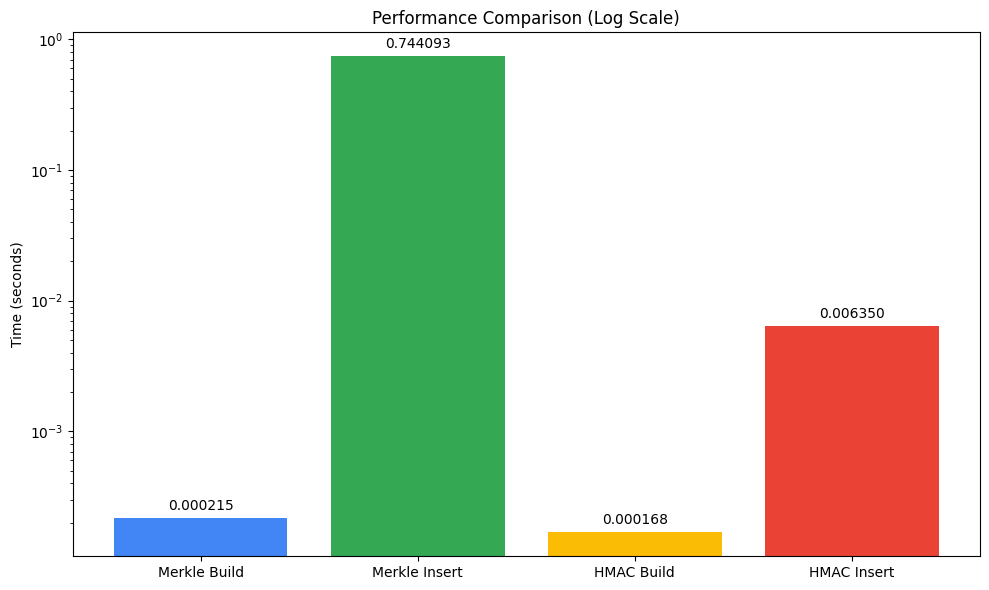

In [22]:
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, times, color=colors)
plt.ylabel("Time (seconds)")
plt.yscale("log")  # 👈 Use log scale
plt.title("Performance Comparison (Log Scale)")

# Add value labels (still works on log scale)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval * 1.1, f"{yval:.6f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
